# <font color="maroon">Chapter 2: Detector Optimization</font>

In the previous chapter, we established that if we have an experimental measurements, $R_\zeta^\theta$ (denoted $R_\zeta^{(\theta,S)}$ for rank-2 tensor correlation functions), which have linear relationships to the correlation function, then we can take linear combinations of the experimental measurements to get so-called *detector responses* which provide correlation time windows, i.e. *detector sensitivities*, $\rho_n(z)$, into the total distribution of correlation times. 

The goal, then, is to find $n$ linear combinations of a set of experimental sensitivies that
- Allow us to also reproduce the original sensitivies to good approximation
    - *This maximizes the extracted information*
- The output detector sensitivities are narrow and well-separated
    - *or match some target function*
    
The detector analysis has been developed over the course of a few publications:

* A graphic approach to detector optimization was introduced in

A. A. Smith, M. Ernst, B. H. Meier. [Optimized ‘detectors’ for dynamics analysis in solid-state NMR.](https://aip.scitation.org/doi/abs/10.1063/1.5013316) J. Chem. Phys. 2018, 148, 045104.

* Usage of singular value decomposition to help optimize detectors was introduced in

A. A. Smith, M. Ernst. B. H. Meier, F. Ferrage. [Reducing bias in the analysis of solution-state NMR data with dynamics detectors.](https://aip.scitation.org/doi/abs/10.1063/1.5111081) J. Chem. Phys. 2019, 151, 034102.
    
* Using linear programming in a fully automatic optimization algorithm is discussed in

K. Zumpfe, A.A. Smith. [Model Free or Not?](https://www.frontiersin.org/articles/10.3389/fmolb.2021.727553/full?&utm_source=Email_to_authors_&utm_medium=Email&utm_content=T1_11.5e1_author&utm_campaign=Email_publication&field=&journalName=Frontiers_in_Molecular_Biosciences&id=727553) Front. Mol. Biosci. 2021,  8, 727553.

    
Let's suppose, then, that we have some $m$ experimental sensitivies. To start, let's suppose we renormalize them to all have a maximum of 1.

In [0]:
# SETUP pyDR
!git clone https://github.com/alsinmr/pyDR_tutorial.git
from pyDR_tutorial import colab_setup

In [3]:
import pyDR
import matplotlib.pyplot as plt
import numpy as np

nmr=pyDR.Sens.NMR()  #NMR is a sensitivity object, containing sensitivity windows for NMR experiments
nmr.new_exper(Type='R1',v0=[400,600,800],Nuc='15N') #Add R1 experiments at 3 magnetic fields
nmr.new_exper(Type='R1p',v0=600,vr=60,v1=[10,22,35,45,50],Nuc='15N') #Add R1p experiments at 5 field strengths

_=nmr.plot_Rz(norm=True)

## Singular Value decomposition
We have eight windows in this example ($R_\zeta^{(\theta,S)}$), but those windows are heavily overlapping in two regions. Then, we may generate good approximations of the eight windows from fewer functions, and we may also should be able to separate regions of sensitivity from the eight windows. We will first decompose the eight windows based on singular value decomposition (this is built-in into the "detector" sensitivity object, called 'r' in the next lines, see r.SVD). We test how well the eight windows can be decomposed based on 1-8 functions, and also plot the new windows based on SVD.

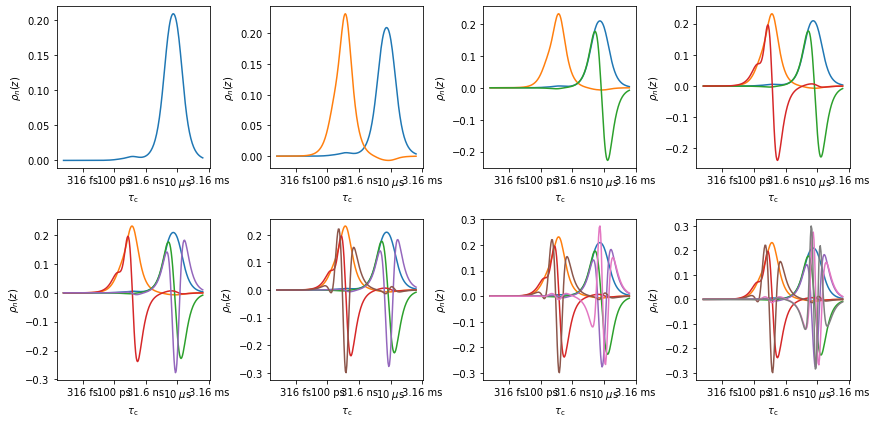

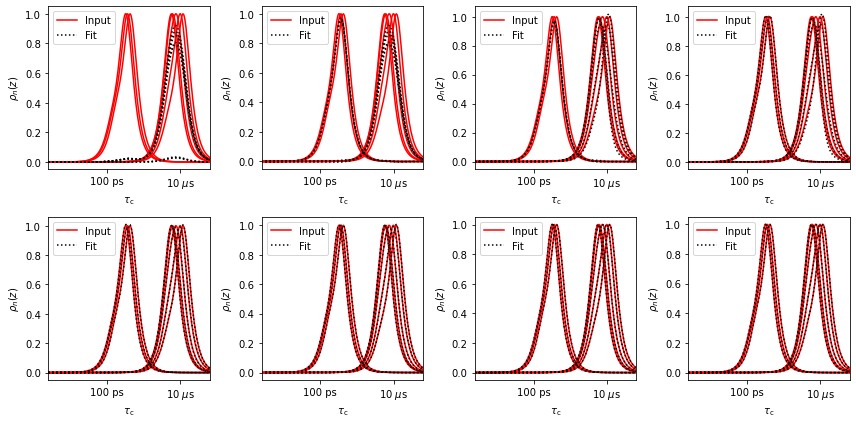

In [75]:
ax0=plt.subplots(2,4)[1].flatten()
ax0[0].figure.set_size_inches([12,6])
ax1=plt.subplots(2,4)[1].flatten()
ax1[0].figure.set_size_inches([12,6])

r=nmr.Detector() #

for n,ax00,ax10 in zip(range(1,9),ax0,ax1):
    r.r_no_opt(n)
    r.plot_rhoz(ax=ax00)
    r.plot_fit(ax=ax10,norm=True)
ax0[0].figure.tight_layout()
ax1[0].figure.tight_layout()

In the top plot, the eight windows are decomposed into up to eight functions. Via singular value decomposition, these functions are orthonormal, meaning the sum of the product of any two of these functions is zero. If we take the sum of the product of one of the functions with itself, we get one (calculate r.rhoz @ r.rhoz.T to check). In the bottom plot, the original windows are reconstructed out of the orthonormal functions. As the number of functions used increases, the reproduction gets better. Only the last calculation yields a perfect reproduction, but by the time we have five functions, the back calculation is extremely good. This suggests that this data set will support fitting with up to five parameters (possibly less for poor signal to noise).

Note that we may prioritize fitting different pieces of experimental data by scaling the original functions. In this case, all functions are scaled to have a maximum of one, given all functions equal priority. If a sensitivity object ('nmr') is produced via loading NMR data from a file, then the median value of each rate constant and its median standard deviation is used for scaling in order to prioritize data with a higher signal-to-noise ratio (nmr.norm is multiplied by each sensitivity, nmr.rhoz to get the scaled sensitivities).

In [76]:
r.rhoz @ r.rhoz.T  #Verify orthonormality of the window functions

array([[ 1.00000000e+00,  1.50920942e-16,  3.89499630e-17,
         3.64291930e-17,  1.45825192e-16, -1.33736338e-16,
        -1.02274146e-16, -3.28445496e-17],
       [ 1.50920942e-16,  1.00000000e+00, -1.04083409e-17,
        -2.22044605e-16, -8.67361738e-19,  5.37764278e-17,
         4.77048956e-18,  3.46944695e-18],
       [ 3.89499630e-17, -1.04083409e-17,  1.00000000e+00,
        -2.77555756e-17, -2.23318542e-16,  2.35271871e-16,
         1.55999752e-16,  7.34716378e-17],
       [ 3.64291930e-17, -2.22044605e-16, -2.77555756e-17,
         1.00000000e+00,  0.00000000e+00,  1.11022302e-16,
         4.33680869e-18, -7.58941521e-19],
       [ 1.45825192e-16, -8.67361738e-19, -2.23318542e-16,
         0.00000000e+00,  1.00000000e+00,  1.24900090e-16,
        -3.38325288e-16, -2.90159606e-17],
       [-1.33736338e-16,  5.37764278e-17,  2.35271871e-16,
         1.11022302e-16,  1.24900090e-16,  1.00000000e+00,
        -5.89805982e-17,  2.60208521e-18],
       [-6.95922269e-17,  5.204170

## Window optimization via linear programming

Above, we showed that the window functions (sensitivities) could be reproduced with a reduced number of functions via singular value decomposition. However, the resulting functions do not make nice windows (top plots), often having significant negative regions and overlap. However, we can reduce the data set first via singular decomposition (above), and second optimize a linear recombination of the results of SVD. 

We have developed an algorithm to do so. We find that we may use [linear programming](https://en.wikipedia.org/wiki/Linear_programming), to fix the value of the function at some correlation to 1, and minimize it elsewhere. For a few correlation times, this produces nice windows, and so it is only a matter of searching for the correct correlation times. (performed in the r.r_auto function). In case one uses too large a number of singular values, this algorithm may become unstable, but usually this only occurs when the data is anyway being overfit. 

Note that running r.r_no_opt() as has been done above for the initial singular value decomposition is not required. This step is always done automatically, and was only shown for demonstration purposes.

Below, we plot from 1 to 8 windows for the 8 experiments, including the fits.

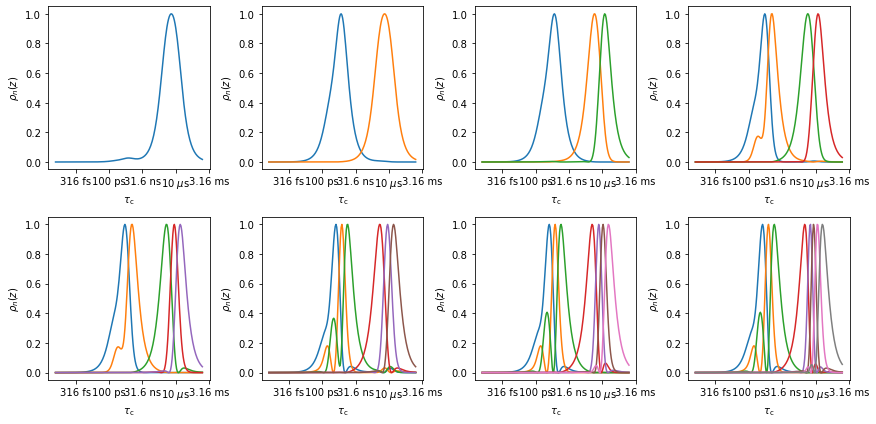

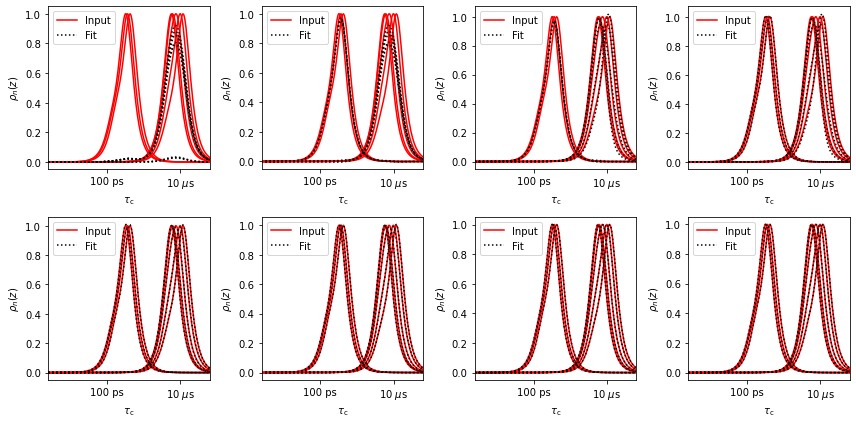

In [77]:
ax0=plt.subplots(2,4)[1].flatten()
ax0[0].figure.set_size_inches([12,6])
ax1=plt.subplots(2,4)[1].flatten()
ax1[0].figure.set_size_inches([12,6])

r=nmr.Detector() #

for n,ax00,ax10 in zip(range(1,9),ax0,ax1):
    r.r_auto(n)
    r.plot_rhoz(ax=ax00)
    r.plot_fit(ax=ax10,norm=True)
ax0[0].figure.tight_layout()
ax1[0].figure.tight_layout()

Note, the back-calculated quality of the experimental sensitivies is fully independent of the optimized shape of the new windows, and only depends on the number of singular values used (compare fit plots). 

An important point: as we increase the number of singular values used, we increase the timescale resolution of the resulting detectors, but when analyze actual data, we will also increase the noise in the resulting data points: this is the usual resolution/signal-to-noise tradeoff. 

## Matching to a target function

The above approach is a way to get the "best" information out of a data set. However, suppose we want to compare dynamics data between two unlike data sets, in particular, what if we want to compare NMR and MD data. From MD data, we calculate correlation functions (for comparison to NMR, these must also be the rank-2 tensor correlation functions). Then, we may want to match the detector windows from the MD data set to the NMR data set. In this case, we no longer use the linear programming approach and instead us a linear least squares to match the functions. We take the detectors for NMR obtained for 5 singular values, generate sensitivies for an MD data set, and produce MD detectors that approximate the NMR detectors.

First, we optimize the nmr data for five detectors and plot the result:

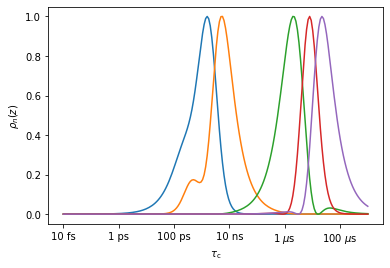

In [78]:
rNMR=nmr.Detector()
_=rNMR.r_auto(5).plot_rhoz()

Next, we suppose we have MD data, sampled every 10 ps out to 1 $\mu$s. We plot the sensitivities of some of the time points.

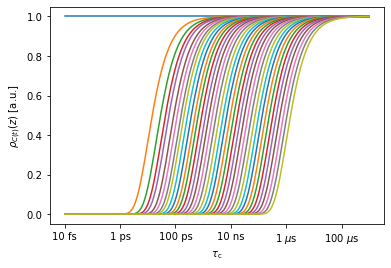

In [81]:
md=pyDR.Sens.MD(t=np.arange(100001)*.01)
_=md.plot_rhoz()

In the MD sensitivity object (md), there are in fact 100001 sensitivities stored, one for each time point. The sensitivity of a time point from an MD-derived correlation function is given by

\begin{equation}
R^\mathrm{MD}_t(z)=\exp(-t/(10^z\cdot\mathrm{ 1 s}))
\end{equation}

Here, $t$ indicates a specific time point in the MD-derived correlation function, and the sensitivity is calculated as a function of the log-correlation time, $z$, as with the NMR-derived correlation functions.

Note that by default, pyDR only plots some of the functions for MD sensitivities, since plotting all 100001 of them would freeze the program for awhile.

Next, we create an md detector object, and use the sensitivity of the nmr detector as a target function for the md detector. Note, to reproduce the 5 NMR detector sensitivities, we need at least 5 singular values for the MD, but we can use more, which will result in some "dummy" sensitivities in the MD that are eventually used to fit the MD data, but may not be particularly interesting to us. We sweep from 5 up to 12 singular values for the example.

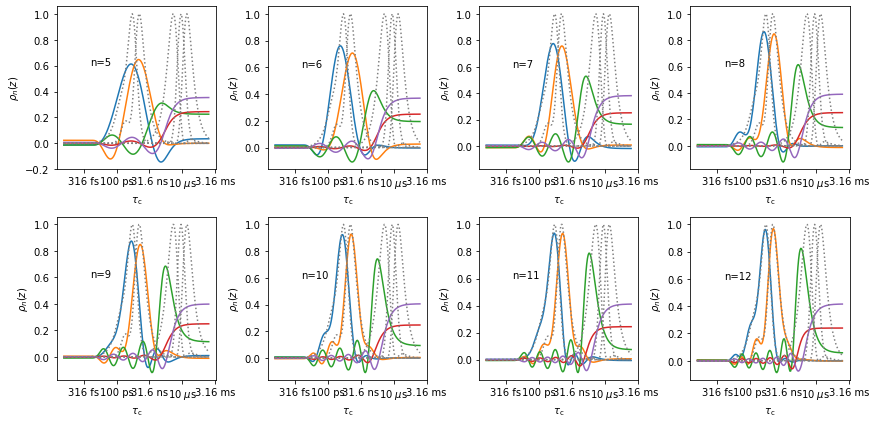

In [82]:
rMD=md.Detector()
rMD.r_no_opt(12) #This is a trick to make the code faster. 
#When we request n singular values, SVD is performed with n values and the result stored for future use
#If we later need n+1 singular values, the SVD must be repeated with n+1.
#But, if we need n-1 singular values, the SVD for n values already contains the required data
target=rNMR.rhoz

ax=plt.subplots(2,4)[1].flatten()
ax[0].figure.set_size_inches([12,6])

for n,ax0 in zip(range(5,13),ax):
    rMD.r_target(target,n)
    rMD.plot_rhoz(ax=ax0,index=range(5))[0].axes
    rNMR.plot_rhoz(ax=ax0,color='grey',linestyle=':')
    ax0.text(-12,.6,f'n={n}')
ax[0].figure.tight_layout()

Above, we see that as the number of singular values increases, the reproduction of the first two detectors (blue, orange, ~1 ns) continually improves. This is due to better timescale resolution for more singular values, but recall that it will be accompanied by decreasing signal-to-noise when analyzing real data. The reproduction of the latter three detectors never becomes acceptable. However, this makes sense: these windows fall at times longer than 1 $\mu$s, so a 1 $\mu$s trajectory cannot easily reproduce these motions  (we print the center of sensitivity for each detector below).

In [83]:
for k,pars in enumerate(rNMR.info):
    print(f'rho0: z0={pars["z0"]:.2f}, <tau_c>={10**pars["z0"]*1e9:.2f} ns')
    

rho0: z0=-9.11, <tau_c>=0.78 ns
rho0: z0=-8.22, <tau_c>=6.02 ns
rho0: z0=-5.86, <tau_c>=1373.66 ns
rho0: z0=-5.09, <tau_c>=8209.87 ns
rho0: z0=-4.48, <tau_c>=33417.59 ns


So, how could we improve the window reproduction for longer correlation times? We would need a longer MD trajectory. So, let us suppose we have 50 $\mu$s instead of 1 $\mu$s. We'll use a longer time step to reduce the amount of data (500 ps timestep).

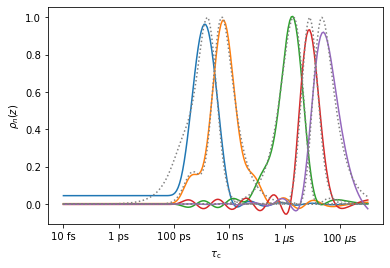

In [84]:
md=pyDR.Sens.MD(t=np.arange(100001)*.5)
rMD=md.Detector()
rMD.r_target(target=target,n=12)
ax=rMD.plot_rhoz(index=range(5))[0].axes
_=rNMR.plot_rhoz(ax=ax,color='grey',linestyle=':')

The detectors sensitive in the microsecond range are much better reproduced, although caution should certainly be taken for the last detector (~33 $\mu$s), which dives below zero at the end of our timescale axis. Note that the first detector (blue, 0.8 ns) is not so well-reproduced anymore, due to the large timestep (500 ps is too long to separate out motions around or faster than this timestep, for example, the 800 ps detector).

## MD detectors optimized only for MD

While we may use detector analysis of MD for comparison, it is also sometimes useful to just optimize the MD detectors for the maximum separation of timescales. Then, we cannot compare to NMR, but indeed detector analysis is a very useful technique for analyzing MD data alone

(for example, see A. A. Smith, E.M. Pacull, S. Stecher, P. W. Hildebrand, A. Vogel, D. Huster. [Analysis of the Dynamics of the Human Growth Hormone Secretagogue Receptor Reveals Insights into the Energy Landscape of the Molecule.](https://doi.org/10.1002/anie.202302003) Angew. Chem. Int. Ed. 2023 )

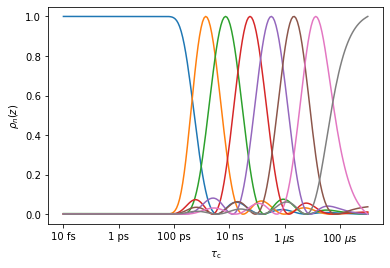

In [86]:
_=rMD.r_auto(8).plot_rhoz()

MD data tends to produce 'ripples' at the baseline, which can be removed in data post-processing